In [21]:
"""
In order to run the code as is, you will need scipy, pandas and tqdm installed 
(although tqdm is only needed for the progress bar, and pandas is only for the autocorrelation function)
All of these can be installed (on linux) from the command interface using 'pip'
""" 

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from MHrank import MH_sample 
from eprank import exprop
import pandas
from cw2 import sorted_barplot

We first need to load the data, stored in "tennis_data.mat". The data consists of an array, $W$ containing the names of each player, and an array, G, containing the results of all of the matches in the season. 

In [22]:
# set seed for reproducibility
np.random.seed(0)
# load data
data = sio.loadmat('tennis_data.mat')
# Array containing the names of each player
W = data['W']
# loop over array to format more nicely
for i, player in enumerate(W):
    W[i] = player[0]
# Array of size num_games x 2. The first entry in each row is the winner of game i, the second is the loser
games = data['G'] - 1
num_players = W.shape[0]
num_games = games.shape[0]

# MCMC sampling (this may take a minute)

In [23]:
# number of iterations -- the more the better!
num_its = 10000
# perform Metropolis MCMC sampling, skill samples is an num_players x num_samples array
skill_samples = MH_sample(games, num_players, num_its)

# discard the first half of the samples (burn-in period)
# skill_samples = skill_samples[:,num_its//2:]

100%|██████████| 10000/10000 [01:52<00:00, 89.16it/s]

Acceptance rate: 0.502


Text(0.5, 1.0, 'Skill samples for player Novak-Djokovic')

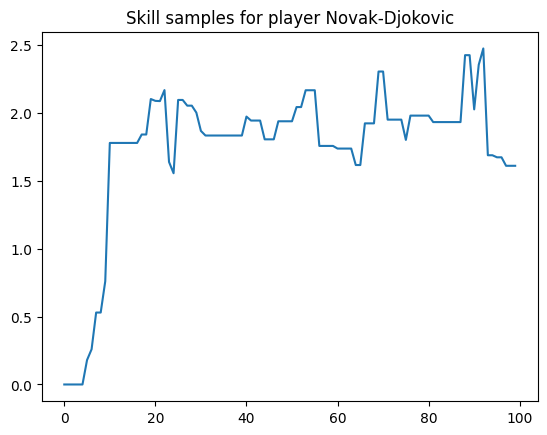

In [4]:
player = 15
plt.plot(skill_samples[player,:100])
plt.title(f'Skill samples for player {W[player][0]}')

Text(0.5, 1.0, 'Smoothed samples for player Rafael-Nadal')

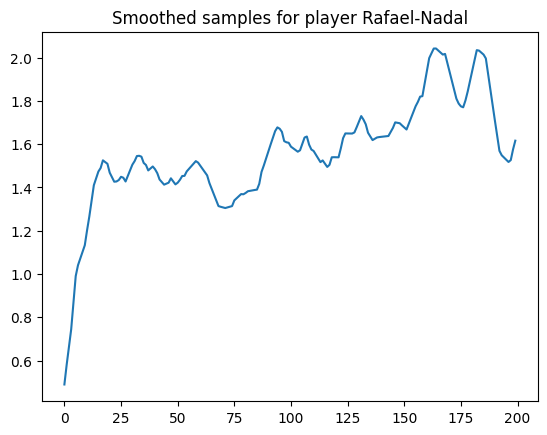

In [5]:
player = 0
plt.plot(np.convolve(skill_samples[player,:], np.ones(10)/10, mode='same')[:200])
plt.title(f'Smoothed samples for player {W[player][0]}')

['Rafael-Nadal']
Autocorrelation time for player Rafael-Nadal: 35.44518438372827


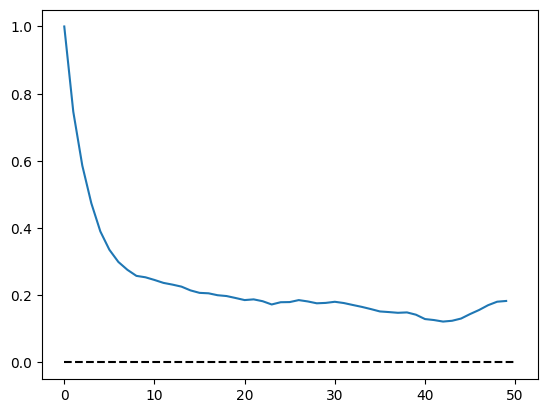

In [6]:
# plotting the autocorrelation function for player i
i = 0
l = 500
max_display = 50
autocor = np.zeros(l)
print(W[i])
for t in range(l):
    autocor[t]=pandas.Series.autocorr(pandas.Series(skill_samples[i,:]),lag=t)
plt.plot(autocor[:max_display])
plt.plot([0,max_display],[0,0],'k--')
autocor_time = np.sum(autocor) * 2 - 1
print(f'Autocorrelation time for player {W[i][0]}: {autocor_time}')

# Expectation propagation ranking

In [7]:
# run message passing algorithm, returns mean and variance for each player
posterior, msg, num_its_conv = exprop(games, num_players, num_its = 5000, return_msg = True)
ep_mean, ep_var = posterior[:,0], posterior[:,1]
print(f'Message passing algorithm converged in {num_its_conv} iterations')

Message passing algorithm converged in 64 iterations


# ArviZ Statistics Check

In [8]:
import arviz as az 
chain = skill_samples[:, :, np.newaxis].T
print(chain.shape)
idata = az.from_dict(posterior={"x": chain})
az.summary(idata)



(1, 10000, 107)


arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],1.604,0.212,1.215,1.999,0.012,0.005,307.0,969.0,NaN
x[1],0.309,0.218,-0.105,0.722,0.010,0.004,444.0,978.0,NaN
x[2],0.843,0.213,0.441,1.256,0.010,0.004,427.0,1027.0,NaN
x[3],0.626,0.204,0.248,1.010,0.010,0.004,395.0,1479.0,NaN
x[4],1.657,0.223,1.246,2.061,0.011,0.005,433.0,1619.0,NaN
...,...,...,...,...,...,...,...,...,...
x[102],-0.797,0.813,-2.279,0.785,0.033,0.018,615.0,954.0,NaN
x[103],-0.569,0.854,-2.136,1.072,0.034,0.019,618.0,1016.0,NaN
x[104],-1.307,0.529,-2.354,-0.385,0.017,0.010,955.0,1463.0,NaN
x[105],-0.381,0.816,-1.837,1.234,0.031,0.018,686.0,1146.0,NaN


In [9]:
summary = az.summary(idata)
n = idata.posterior.sizes["draw"]
iat = n / summary["ess_bulk"]

print(iat)

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


x[0]      32.573290
x[1]      22.522523
x[2]      23.419204
x[3]      25.316456
x[4]      23.094688
            ...    
x[102]    16.260163
x[103]    16.181230
x[104]    10.471204
x[105]    14.577259
x[106]    17.667845
Name: ess_bulk, Length: 107, dtype: float64


# Top 4 

In [10]:
i = 15
burn_in = 300

top4_ind = np.argsort(-ep_mean)[:4]
for i in top4_ind:
    print(f'Player: {W[i]}')
    print(f'MCMC mean skill: {np.mean(skill_samples[i,burn_in:])}')
    print(f'EP mean skill: {ep_mean[i]}')
    print(f'MCMC skill std: {np.std(skill_samples[i,burn_in:])}')
    print(f'EP skill std: {np.sqrt(ep_var[i])}')
    print('---')

Player: ['Novak-Djokovic']
MCMC mean skill: 2.052273768807581
EP mean skill: 2.0782537140925776
MCMC skill std: 0.23283685461819287
EP skill std: 0.21157042417893454
---
Player: ['Roger-Federer']
MCMC mean skill: 1.6553263636063276
EP mean skill: 1.6861540327908835
MCMC skill std: 0.21896357654205803
EP skill std: 0.19740221814869743
---
Player: ['Rafael-Nadal']
MCMC mean skill: 1.6021481435600258
EP mean skill: 1.6342955604786866
MCMC skill std: 0.20933367890343813
EP skill std: 0.19786132355748517
---
Player: ['Andy-Murray']
MCMC mean skill: 1.4061654552194656
EP mean skill: 1.4149944264024021
MCMC skill std: 0.21761062451863322
EP skill std: 0.19007007248024643
---


In [21]:
from scipy.stats import norm
top4_ind = np.argsort(-ep_mean)[:4]
top4_players = W[top4_ind][:,0].tolist()
top4_skill_mcmc = np.mean(skill_samples[top4_ind,burn_in:], axis=1)
top4_skill_ep = ep_mean[top4_ind]

gap = 9

print("Top 4 players win rate according to MCMC:")
str_0 = "   ".join(top4_players[i] for i in range(4))
print(" " * 15 + str_0)
for i in range(4):
    print(top4_players[i], end=" " * gap)
    for j in range(4):
        if i != j:
            win_prob_mcmc = norm.cdf(top4_skill_mcmc[i] - top4_skill_mcmc[j] / np.sqrt(1 + ep_var[i] + ep_var[j]))
            print(f"{win_prob_mcmc:.3f}" + " " * gap, end='')
        else:
            print(" - " + " " * gap, end='')
    print('\n')

print("\n")

print("Top 4 players win rate according to EP:")
str_0 = "   ".join(top4_players[i] for i in range(4))
print(" " * 15 + str_0)
for i in range(4):
    print(top4_players[i], end=" " * gap)
    for j in range(4):
        if i != j:
            win_prob_mcmc = norm.cdf((top4_skill_ep[i] - top4_skill_ep[j]) / np.sqrt(1 + ep_var[i] + ep_var[j]) )
            print(f"{win_prob_mcmc:.3f}" + " " * gap, end='')
        else:
            print(" - " + " " * gap, end='')
    print('\n')


Top 4 players win rate according to MCMC:
               Novak-Djokovic   Roger-Federer   Rafael-Nadal   Andy-Murray
Novak-Djokovic          -          0.677         0.694         0.755         

Roger-Federer         0.375          -          0.545         0.616         

Rafael-Nadal         0.354         0.503          -          0.594         

Andy-Murray         0.280         0.422         0.442          -          



Top 4 players win rate according to EP:
               Novak-Djokovic   Roger-Federer   Rafael-Nadal   Andy-Murray
Novak-Djokovic          -          0.647         0.666         0.740         

Roger-Federer         0.353          -          0.520         0.604         

Rafael-Nadal         0.334         0.480          -          0.584         

Andy-Murray         0.260         0.396         0.416          -          



In [12]:
print("Top 4 players skill diff probability according to EP:")
str_0 = "   ".join(top4_players[i] for i in range(4))
print(" " * 15 + str_0)
for i in range(4):
    print(top4_players[i], end=" " * gap)
    for j in range(4):
        if i != j:
            win_prob_ep = norm.cdf((top4_skill_ep[i] - top4_skill_ep[j]) / np.sqrt(ep_var[i] + ep_var[j]))
            print(f"{win_prob_ep:.3f}" + " " * gap, end='')
        else:
            print(" - " + " " * gap, end='')
    print('\n')

Top 4 players skill diff probability according to EP:
               Novak-Djokovic   Roger-Federer   Rafael-Nadal   Andy-Murray
Novak-Djokovic          -          0.917         0.946         0.995         

Roger-Federer         0.083          -          0.574         0.852         

Rafael-Nadal         0.054         0.426          -          0.807         

Andy-Murray         0.005         0.148         0.193          -          



# Nadal and Federer

In [13]:
federer = top4_ind[1]
nadal = top4_ind[2]
samples = skill_samples[:, burn_in:]

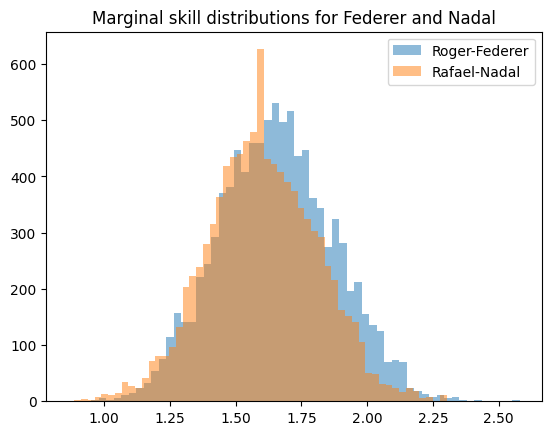

In [14]:
plt.hist(samples[federer, :], bins=60, alpha=0.5)
plt.hist(samples[nadal, :], bins=60, alpha=0.5)
plt.title('Marginal skill distributions for Federer and Nadal')
plt.legend(W[[federer, nadal],0])
plt.show()

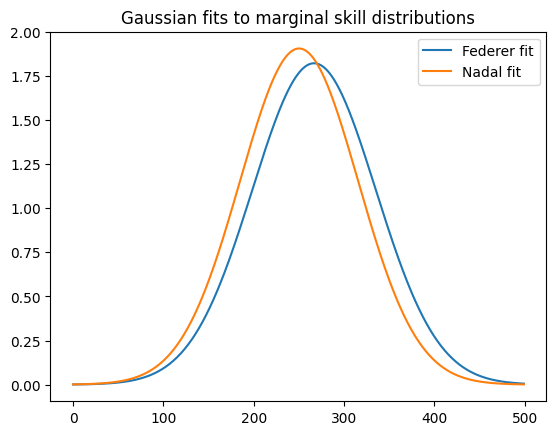

In [15]:
mu_federer, sigma_federer = norm.fit(samples[federer, :])
mu_nadal, sigma_nadal = norm.fit(samples[nadal, :])
plot_axis = np.linspace(0.8, 2.4, 500)
plt.plot(norm.pdf(plot_axis, loc=mu_federer, scale=sigma_federer), label='Federer fit')
plt.plot(norm.pdf(plot_axis, loc=mu_nadal, scale=sigma_nadal), label='Nadal fit')
plt.title('Gaussian fits to marginal skill distributions')
plt.legend()
plt.show()

In [22]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(samples[federer, :],
                          samples[nadal, :], equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: 17.288496830819128
p-value: 1.8130330692781442e-66


Text(0, 0.5, 'Nadal skill')

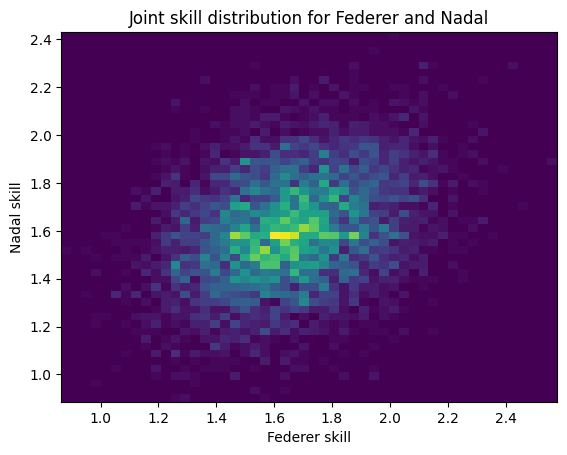

In [16]:
joint_sample = np.stack((samples[federer, :], samples[nadal, :]), axis=1)
plt.hist2d(joint_sample[:, 0], joint_sample[:, 1], bins=50)
plt.title('Joint skill distribution for Federer and Nadal')
plt.xlabel('Federer skill')
plt.ylabel('Nadal skill')

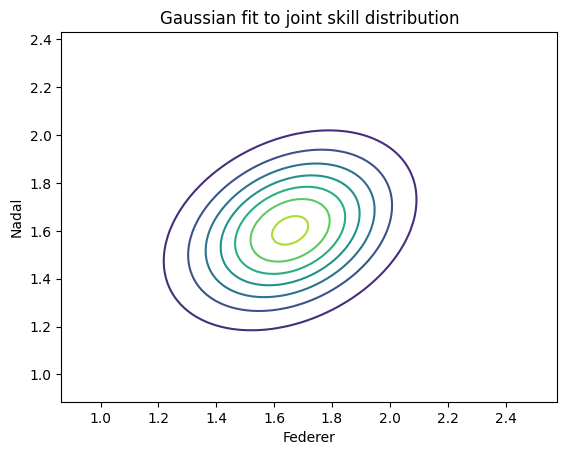

In [17]:
from scipy.stats import multivariate_normal

mean = np.mean(joint_sample, axis=0)
cov = np.cov(joint_sample, rowvar=False)
x = np.linspace(joint_sample[:,0].min(), joint_sample[:,0].max(), 100)
y = np.linspace(joint_sample[:,1].min(), joint_sample[:,1].max(), 100)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

rv = multivariate_normal(mean, cov)
plt.contour(X, Y, rv.pdf(pos))
plt.title("Gaussian fit to joint skill distribution")
plt.xlabel("Federer")
plt.ylabel("Nadal")
plt.show()

Occurence of samples where Federer is better: 5714
Occurence of samples where Nadal is better: 3986


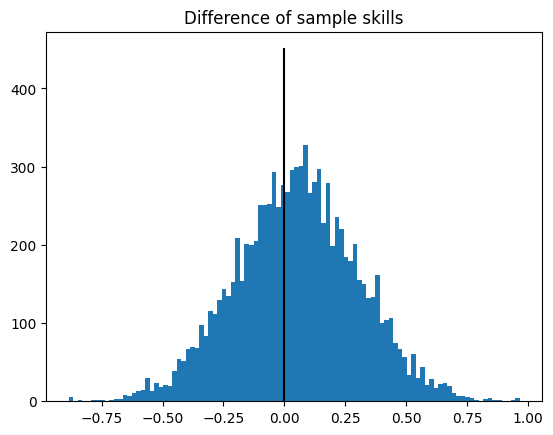

In [18]:
print("Occurence of samples where Federer is better:", np.where(samples[federer] > samples[nadal])[0].size)
print("Occurence of samples where Nadal is better:", np.where(samples[federer] < samples[nadal])[0].size)
plt.hist(samples[federer, :] - samples[nadal, :], bins=100)
plt.title("Difference of sample skills")
plt.plot([0,0], [0, 450], color=(0,0,0))
plt.show()

In [19]:
win_count = np.bincount(games[:, 0])
lose_count = np.bincount(games[:, 1])